In [2]:
using Pkg; Pkg.activate(".")
using Random, Distributions, LinearAlgebra, Statistics
using Plots, Plots.PlotMeasures, StatsPlots, LaTeXStrings
using Zygote, Flux, Turing, MCMCChains, AdvancedMH, Optim, AdvancedHMC
using DistributionsAD, AdvancedVI, Distributions
using DiffEqFlux, DifferentialEquations, DiffEqCallbacks
using LinearAlgebra, SymPy, StatsBase
using AdaptiveMCMC, DataFrames, KernelDensity
using CSV, Trapz, QuadGK, DelimitedFiles, Optim

  Activating new project at `~/Library/CloudStorage/OneDrive-UCB-O365/SpringMassDamper/RoundRobin/third`


In [3]:
times = readdlm("../mass-spring-dampers/experimental_data/k1m2h1/times.mat", Float32)
expTimes = vcat(times[1,1:end])
filteredTimes = filter(x -> 0.01<=x<=0.5, expTimes)
expTimes2 = filteredTimes

2509-element Vector{Float32}:
 0.010117556
 0.010312872
 0.010508188
 0.010703504
 0.01089882
 0.011094136
 0.011289452
 0.011484768
 0.011680084
 0.0118754
 0.012070716
 0.012266032
 0.012461348
 ⋮
 0.49782178
 0.4980171
 0.49821243
 0.49840775
 0.49860305
 0.49879837
 0.4989937
 0.499189
 0.4993843
 0.49957964
 0.49977496
 0.49997026

In [4]:
indices = findall(x -> 0.01 <= x <= 0.5, expTimes)

2509-element Vector{Int64}:
  104
  105
  106
  107
  108
  109
  110
  111
  112
  113
  114
  115
  116
    ⋮
 2601
 2602
 2603
 2604
 2605
 2606
 2607
 2608
 2609
 2610
 2611
 2612

In [5]:
#Defining Constants
D = 0.0485
Df = 0.001

m=0.9249
mf=9.33

k = 26912.6
b = 1.70338
g0 =26.1782
kf = 180.714
bf = 0.176391

uInitial = [0.019893, 0.0200593, 0.00754123, 0.00832097]
u0=uInitial

tspan = (expTimes2[1], expTimes2[end])
storedTimes = expTimes2
inadType=1

params = [k,b,bf,g0,kf]
pTrue = vcat(params,u0)

# For high fidelity
ki = 25788
bi = 18.206
g0i =26
kfi = 722.0
bfi = 0.176

k1=40000
k2=5

mi=0.9249
mfi=9.33

paramsHigh =[ki,bi,bfi,g0i,kfi,k1,k2]
pTrueHigh=vcat(paramsHigh,u0)

11-element Vector{Float64}:
 25788.0
    18.206
     0.176
    26.0
   722.0
 40000.0
     5.0
     0.019893
     0.0200593
     0.00754123
     0.00832097

In [6]:
function lowFidelity(du,u,p,t)
    k = p[1]
    b = p[2]
    bf = p[3]
    g0 = p[4]
    kf = p[5]

    if inadType == 1 || inadType == 2
        x = u[1:2]
        v = u[3:4]
        
        du[1:2]=v
        
        du[3]=(1/m)*(-b*(v[1]-v[2])-g0*v[1]-k*(x[1]-x[2]))
        du[4]=(1/mf)*(b*(v[1]-v[2])+k*(x[1]-x[2])-bf*v[2]-kf*x[2])
    end
    return du
end

function highFidelity(du,u,p,t)
    ki = p[1]
    bi = p[2]
    bfi = p[3]
    g0i = p[4]
    kfi = p[5]

    k1 = p[6]
    k2 = p[7]

    if inadType == 3 || inadType == 4
        x = u[1:2]
        v = u[3:4]
        
        du[1:2]=v
        
        du[3]=(1/mi)*(-bi*(v[1]-v[2])-g0i*v[1]-(ki*(x[1]-x[2])+k1*abs(x[1]-x[2])*(x[1]-x[2])+k2*(x[1]-x[2])^3))
        du[4]=(1/mfi)*(bi*(v[1]-v[2])+ki*(x[1]-x[2])-bfi*v[2]-kfi*x[2])
    end
    return du
end

highFidelity (generic function with 1 method)

In [7]:
function takeDerivs(p; fp=false)
    vals = SavedValues(Float64, Vector{Float64})
    cb = SavingCallback((u,t,integrator)->integrator(t,Val{1}), vals, saveat=storedTimes)
    lowFidel = ODEProblem(lowFidelity, p[6:9],tspan,p)
    sol = Array(solve(lowFidel,RadauIIA5(), u0=p[6:9], p=p,saveat=storedTimes, reltol=1e-4, abstol=1e-4, callback=cb))
        
    derivs = mapreduce(permutedims, vcat, vals.saveval)
    
    return sol, derivs
end

function takeDerivsInad(p; fp=false)
    vals = SavedValues(Float64, Vector{Float64})
    cb = SavingCallback((u,t,integrator)->integrator(t,Val{1}), vals, saveat=storedTimes)
    highFidel = ODEProblem(highFidelity, p[8:11],tspan,p)
    sol = Array(solve(highFidel,RadauIIA5(), u0=p[8:11], p=p,saveat=storedTimes, reltol=1e-4, abstol=1e-4, callback=cb))
        
    derivs = mapreduce(permutedims, vcat, vals.saveval)
    
    return sol, derivs
end

takeDerivsInad (generic function with 1 method)

In [8]:
#solution, derivatives = takeDerivs(pTrue)

In [9]:
data_accm = readdlm("../mass-spring-dampers/experimental_data/k1m2h1/acc_output5.mat", Float32)
data_accm_pr = vcat(data_accm[1,1:end])
data_accmf = readdlm("../mass-spring-dampers/experimental_data/k1m2h1/acc_w_output5.mat", Float32)
data_accmf_pr = vcat(data_accm[1,1:end])

accm = data_accm_pr[104:2612, :]
accf = data_accmf_pr[104:2612, :]

2509×1 Matrix{Float32}:
 5.6876388
 5.6732774
 5.6666956
 5.6170297
 5.562577
 5.4776063
 5.3848567
 5.2723603
 5.1461015
 5.033605
 4.9276915
 4.819982
 4.7427907
 ⋮
 0.051461015
 0.050264247
 0.05086263
 0.048469096
 0.050264247
 0.040690105
 0.048469096
 0.04906748
 0.04727233
 0.050264247
 0.05684647
 0.04966586

In [10]:
# # plot(storedTimes,accm)
# # plot!(storedTimes, derivatives[:,3])
# # xlims!(0,0.5)

# plot(storedTimes,accm, label ="experiment",title="m=2 and k=1", linewidth=1.5, color=:blue)
# plot!(storedTimes, derivatives[:,3], label="low fidelity", linestyle=:dash, linewidth=2, color=:red)
# xlabel!("Time")
# ylabel!("Acceleration")
# #savefig("RRLogNormalm2k1_not_recal.png")

In [11]:
dfInad = CSV.read("logNormalMCMCChains_M1K1_No_Hyper_Trial6_200000_L5_Inad.csv", DataFrame)
df = CSV.read("logNormalMCMCChains_M1K1_No_Hyper_Trial3_200000_L5_Updated_Priors_2.csv", DataFrame)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
2,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
3,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
4,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
5,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
6,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
7,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
8,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
9,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707


In [12]:
sdf = df[1:200:end, :]
sdfInad = dfInad[1:200:end, :]

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,26891.4,10.6128,0.178966,22.7402,427.133,520.896,19926.5,0.00501586,0.00520786,0.0270032,0.0262771
2,26929.3,10.8334,0.179328,22.516,444.949,423.35,19806.7,0.00499682,0.00519117,0.0273029,0.0268321
3,26957.1,10.1921,0.175331,22.8754,453.431,438.288,20182.5,0.00459653,0.00478915,0.0271625,0.0267064
4,26976.5,10.9473,0.172229,22.4359,466.38,502.021,19817.5,0.00446568,0.00465951,0.0273486,0.0272687
5,26889.9,10.4496,0.175571,22.703,438.362,503.608,20352.1,0.00455412,0.00474815,0.0273063,0.0268409
6,26909.1,10.5017,0.178036,22.7381,437.664,422.057,19985.0,0.00501092,0.00520356,0.0270827,0.0266063
7,26976.7,10.1216,0.177175,22.6962,459.515,461.683,20808.7,0.00434869,0.00454063,0.027146,0.0269022
8,26966.0,10.4159,0.17753,22.6326,453.201,436.758,20491.4,0.00455094,0.00474341,0.0271786,0.0268948
9,26964.3,10.4509,0.175745,22.5319,432.977,432.942,20217.3,0.00503632,0.00522741,0.0269465,0.0267224


In [115]:
sdf

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,27057.5,10.5294,0.176822,22.7293,456.905,0.00461936,0.00481156,0.0261288,0.0277707
2,27044.9,10.6089,0.176254,22.845,453.087,0.00472638,0.00491921,0.0261579,0.0277679
3,27042.1,10.6849,0.175232,22.7924,436.509,0.00508333,0.00527616,0.0261013,0.0277398
4,27048.3,10.6107,0.176171,22.7011,450.519,0.00482496,0.0050177,0.0261801,0.0277472
5,27043.6,10.6006,0.176507,22.7399,451.801,0.00479599,0.00498893,0.0262004,0.0277707
6,27039.7,10.6095,0.176839,22.8183,453.058,0.00474726,0.00494045,0.0262136,0.0278179
7,27005.1,10.3974,0.177252,22.8217,463.678,0.00445643,0.00464894,0.0261508,0.0277937
8,27005.5,10.4383,0.178146,22.7861,460.186,0.00459188,0.00478467,0.0261796,0.0278948
9,26979.5,10.52,0.177855,22.8496,463.659,0.00451252,0.0047059,0.0262398,0.0278425


In [13]:
nTrajInad=801
nTraj=801

801

In [14]:
scombinedpsInad = [ [sdfInad[:, :x1][i], sdfInad[:, :x2][i], sdfInad[:, :x3][i], sdfInad[:, :x4][i], sdfInad[:, :x5][i], sdfInad[:, :x6][i], sdfInad[:, :x7][i], sdfInad[:, :x8][i], sdfInad[:, :x9][i], sdfInad[:, :x10][i], sdfInad[:, :x11][i]] for i in 1:nTrajInad ]
scombinedps = [ [sdf[:, :x1][i], sdf[:, :x2][i], sdf[:, :x3][i], sdf[:, :x4][i], sdf[:, :x5][i], sdf[:, :x6][i], sdf[:, :x7][i], sdf[:, :x8][i], sdf[:, :x9][i]] for i in 1:nTraj ]


801-element Vector{Vector{Float64}}:
 [27057.5178197034, 10.529387429054468, 0.17682238902072256, 22.72929012280119, 456.905281819236, 0.004619358710235171, 0.0048115601014465095, 0.026128773089968346, 0.027770735774962037]
 [27044.9154665999, 10.608883977200906, 0.176254496539885, 22.844963581138984, 453.08723735979464, 0.004726375931217274, 0.004919214832242565, 0.02615789389821738, 0.02776788010708422]
 [27042.084578849554, 10.68491713181883, 0.1752323010139153, 22.792439498058524, 436.50926080784564, 0.005083333715064677, 0.005276159209617795, 0.026101298307203872, 0.027739764469303815]
 [27048.25069744082, 10.61074980546265, 0.1761713472447085, 22.70110438521588, 450.51862243908755, 0.00482496057264166, 0.0050177039047272455, 0.02618009903746026, 0.027747236717647332]
 [27043.596595996823, 10.600588128436774, 0.17650709615882482, 22.73989321912171, 451.8011063877976, 0.00479599324367715, 0.004988928626606704, 0.026200395363788848, 0.02777066764144088]
 [27039.6732021092, 10.609547

In [19]:
inadType=1
MCMC_results=[]
for param in scombinedps
    pTrue = param
    
    solution, derivatives = takeDerivs(pTrue)
    
    push!(MCMC_results, (derivatives[:,3]))
end
    

In [15]:
inadType=3
MCMC_resultsInad=[]
for param in scombinedpsInad
    pTrue = param
    
    solution, derivatives = takeDerivsInad(pTrue)
    
    push!(MCMC_resultsInad, (derivatives[:,3]))
end

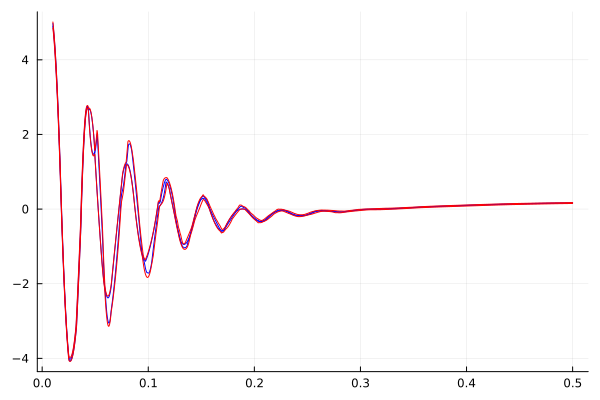

In [20]:
ytrajectories = [MCMC_results[i] for i in 1:nTraj]
trajectories = hcat(ytrajectories...)

quantilesToPlot = [0.25,0.75,0.025,0.975]
function computeQuantiles(data, quantiles)
    return [quantile(data, q) for q in quantiles]
end

quantile_data = mapslices(data -> computeQuantiles(data, quantilesToPlot), trajectories, dims=2)

quantile50L = quantile_data[:, 1]
quantile50U = quantile_data[:, 2]
quantile95L = quantile_data[:, 3]
quantile95U = quantile_data[:, 4]

plot(storedTimes, quantile50L, label=nothing, color=:blue)
plot!(storedTimes, quantile50U, label=nothing, color=:blue)
plot!(storedTimes, quantile95L, label=nothing, color=:red)
plot!(storedTimes, quantile95U, label=nothing, color=:red)

In [21]:
saverage_trajectory = mean(trajectories, dims=2)
savg = vec(saverage_trajectory)

2509-element Vector{Float64}:
 4.9364550562830605
 4.884889541332099
 4.829894969290525
 4.771471340232267
 4.709618653935515
 4.644336910749865
 4.575626110391773
 4.503486252843924
 4.427917338138048
 4.348919365748945
 4.266492338019192
 4.18063624952233
 4.091351109341671
 ⋮
 0.16280358984937604
 0.1628613830852592
 0.16291892638372202
 0.16297619460933843
 0.16303317537287937
 0.16308989828943934
 0.16314635340927353
 0.16320249636932474
 0.16325836766437352
 0.16331395868146267
 0.16336926943962155
 0.1634242965017898

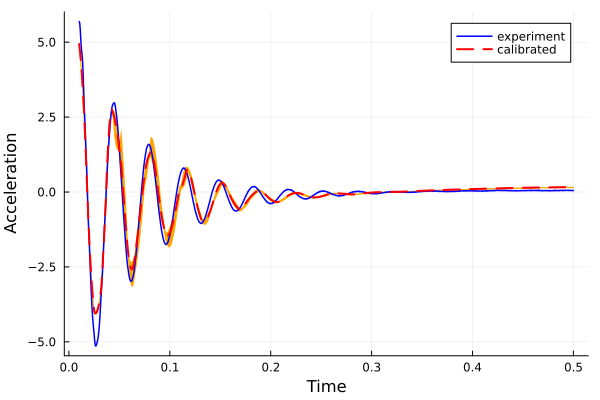

In [22]:
fill50=plot(storedTimes,quantile50L,fillrange=quantile50U, fillalpha=0.75, fillcolor=:orange,color=:orange, label=nothing)
fill95=plot(storedTimes,quantile95L,fillrange=quantile95U, fillalpha=1.0, fillcolor=:orange,color=:orange, label=nothing)

p4=plot(fill50)
p4=plot!(fill95)
p4=plot!(storedTimes,accm, label ="experiment", linewidth=1.5, color=:blue)
p4=plot!(storedTimes, savg, label="calibrated", linestyle=:dash, linewidth=2, color=:red)
xlabel!("Time")
ylabel!("Acceleration")
#savefig("calibrated_lognormal_m2k1_graph.png")

In [23]:
seedNum=1000
function predictiveAssessment(enriched, observed; alpha =0.05)
    numObs = length(observed)
    gammas = zeros(numObs)
    numSamples = (size(enriched)[2])
    Random.seed!(seedNum)
    numObsError = 100
    
    predictions = zeros(numSamples, numObs)

    postPred = zeros(numObs, numSamples*numObsError)
    
    for j in 1:numObs      
        for k in 1:numSamples
            mu = enriched[j,k]
            postPred[j,(k-1)*numObsError+1:(k-1)*numObsError+numObsError]= rand(Normal(mu,0.1),numObsError)
        end
        density = kde(postPred[j,:])
        ik=InterpKDE(density)
        minf = minimum(postPred[j,:])
        maxf = maximum(postPred[j,:])
        xs = LinRange(minf,maxf,200)
        fpdf = pdf(ik,xs)
        fpdfLen = length(fpdf)
        pofy=pdf(ik,observed[j])
            
        for l in 1:fpdfLen
            if fpdf[l]>pofy
                fpdf[l]=0.
            end
        end
        gamma = -trapz(fpdf,xs)
        gammas[j]=gamma
    end
    return gammas, postPred
    
end

function fractionGamma(gamma;alpha=0.05)
    numObs = length(gamma)
    tau = alpha/numObs
    count = 0
    for i in 1:numObs
        if gamma[i]<tau
            count+=1
        end
    end
    count/numObs
end

fractionGamma (generic function with 1 method)

In [83]:
Gs=predictiveAssessment(trajectories,accm)

([-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  0.2644152696385135, 0.25279250909324685, 0.26106700048871584, 0.22225154458170693, 0.24752219540616233, 0.25710734417857983, 0.24113001569634204, 0.2573096901665559, 0.2892159577795655, 0.25381756242564496], [4.791885897183332 5.194029818164447 … 5.054176362121245 5.007988083685751; 4.970870532387785 4.998470902189251 … 4.911082202283153 4.831251600000165; … ; 0.19971542192053945 0.1267800493171001 … 0.3276461414211505 0.2552322213807279; 0.08175912536871136 0.19948039907442605 … 0.26171515033322196 0.19443747161960215])

In [84]:
GammaVals = Gs[1]
posteriors=Gs[2]

2509×120100 Matrix{Float64}:
 4.79189    5.19403     4.99126     …  4.95092    5.05418      5.00799
 4.97087    4.99847     4.93405        4.82276    4.91108      4.83125
 4.80154    4.8042      5.00157        4.73143    4.96645      4.76986
 4.8335     4.77219     4.77408        4.68586    4.83427      4.67908
 4.908      4.67618     4.83496        4.85009    4.91819      4.66453
 4.76615    4.80418     4.9598      …  4.74871    4.59951      4.79886
 4.64932    4.52981     4.642          4.70347    4.59265      4.37288
 4.47073    4.83372     4.66623        4.43022    4.38433      4.57277
 4.52585    4.25821     4.63329        4.33755    4.51524      4.42203
 4.45222    4.59462     4.34214        4.34817    4.61107      4.38227
 4.31865    4.37336     4.1312      …  4.27276    4.395        4.31735
 4.30454    4.11716     4.37174        4.26803    4.33197      4.20937
 4.25094    4.12908     4.1858         3.87726    4.06244      4.21124
 ⋮                                  ⋱           

In [85]:
fractionGamma(GammaVals)

0.08688720605819052

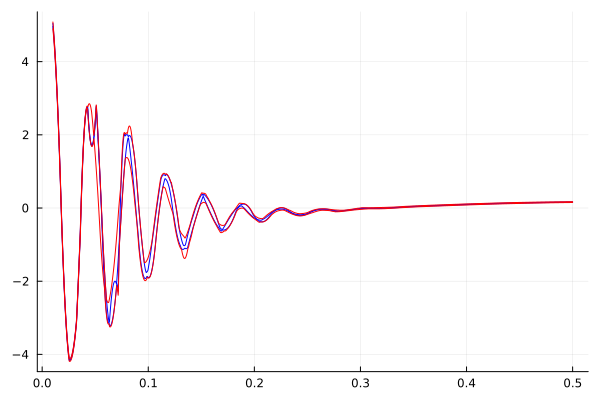

In [24]:
ytrajectoriesInad = [MCMC_resultsInad[i] for i in 1:nTrajInad]
trajectoriesInad = hcat(ytrajectoriesInad...)

quantile_dataInad = mapslices(data -> computeQuantiles(data, quantilesToPlot), trajectoriesInad, dims=2)

quantile50LInad = quantile_dataInad[:, 1]
quantile50UInad = quantile_dataInad[:, 2]
quantile95LInad = quantile_dataInad[:, 3]
quantile95UInad = quantile_dataInad[:, 4]

plot(storedTimes, quantile50LInad, label=nothing, color=:blue)
plot!(storedTimes, quantile50UInad, label=nothing, color=:blue)
plot!(storedTimes, quantile95LInad, label=nothing, color=:red)
plot!(storedTimes, quantile95UInad, label=nothing, color=:red)

In [25]:
average_trajectoryInad = mean(trajectoriesInad, dims=2)
avgInad = vec(average_trajectoryInad)

2509-element Vector{Float64}:
 5.004153234513939
 4.941333426162713
 4.8753638725140815
 4.806244573486338
 4.733975529324633
 4.65855673939686
 4.5799882047629765
 4.498269924485699
 4.413401899376944
 4.3253841286306445
 4.234216611702197
 4.139899351629356
 4.042432344228886
 ⋮
 0.16035319816973806
 0.1604048981216528
 0.16045635519717438
 0.16050757453090772
 0.1605585622421787
 0.16060934737949273
 0.16065989296974917
 0.1607101833746705
 0.16076023917946297
 0.16081007785719345
 0.16085964856642265
 0.1609089693488381

In [30]:
fill50Inad=plot(storedTimes,quantile50LInad,fillrange=quantile50UInad, fillalpha=0.75, fillcolor=:orange,color=:orange, label=nothing)
fill95Inad=plot(storedTimes,quantile95LInad,fillrange=quantile95UInad, fillalpha=1.0, fillcolor=:orange,color=:orange, label=nothing)

p3=plot(fill50Inad)
p3=plot!(fill95Inad)
p3=plot!(storedTimes,accm, label ="experiment", linewidth=1.5, color=:blue)
p3=plot!(storedTimes, avgInad, label="enriched", linestyle=:dash, linewidth=2, color=:red)
xlabel!("Time")
ylabel!("Acceleration")
savefig("enriched_lognormal_m2k1_graph_final.png")

"/Users/rachelwashington/Library/CloudStorage/OneDrive-UCB-O365/SpringMassDamper/RoundRobin/third/enriched_lognormal_m2k1_graph_final.png"

In [27]:
GsInad=predictiveAssessment(trajectoriesInad,accm)

([-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  0.28346276553734706, 0.2696910443185763, 0.26679527686487786, 0.2292158141209266, 0.25704713562228293, 0.28307678837464834, 0.266524258141782, 0.2713291931850211, 0.29804085906138084, 0.2662592830182822], [4.702709363372475 5.10485328435359 … 4.960863011836993 5.032420290151778; 4.934571247966944 4.783847664601884 … 4.998446250380926 4.740668846099831; … ; 0.024599108801552153 0.046151640629742904 … 0.0926800858386144 0.15052377676415357; 0.15287911468806717 0.052411021239971545 … -0.007335093917587369 0.14937554327002342])

In [28]:
GammaValsInad = GsInad[1]
posteriorsInad=GsInad[2]

2509×80100 Matrix{Float64}:
 4.70271     5.10485    4.90208    …  5.14047    4.96086     5.03242
 4.93457     4.78385    4.76477       4.83746    4.99845     4.74067
 4.81617     4.81971    4.74476       4.79891    5.00543     4.75477
 4.76715     4.5153     4.55624       4.87224    4.73384     4.4909
 4.4151      4.52592    4.50736       4.7734     4.87169     4.75788
 4.56818     4.61189    4.42037    …  4.5385     4.66805     4.68663
 4.57714     4.57661    4.53719       4.55737    4.58111     4.52072
 4.34706     4.28507    4.24744       4.5174     4.47939     4.53698
 4.29147     4.27721    4.37012       4.39591    4.4633      4.43947
 4.34099     4.1849     4.16772       4.36144    4.36167     4.48505
 4.14532     4.03927    4.20208    …  4.19417    4.22709     4.37324
 4.15041     4.19026    4.13043       4.11291    4.13129     4.17182
 3.80613     3.74345    3.90521       4.08506    4.04475     4.08552
 ⋮                                 ⋱                         
 0.124419   -0

In [29]:
fractionGamma(GammaValsInad)

0.05460342766042248